# Задание 3

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from string import punctuation

[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# создадим два датафрейма на основе csv файлов
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [31]:
df_train

,text,label
0,На нас обиделась Оля....Жизнь потеряла смысл. ...,0
1,RT @PolinaZuzy: http://t.co/ZYwbUowIti единств...,1
2,"@AHamueva Машину назвать малышкой,мать ты ебу ...",1
3,RT @malina23_: отличный день в школе!:*теперь ...,1
4,@Serebryakovaaa не то слово))) у него что ни м...,1
...,...,...
136095,А Зоя и Рита Шабановы все-таки сучки. Р.S. М...,1
136096,@nvarlygina я все пропустила!:( ну хоть ты заг...,0
136097,"RT @milkiwey_: выходные были хорошими, даже яр...",1
136098,"@leshqa_meow ахахах, ну ты же стааарше меня, м...",1


<AxesSubplot: >

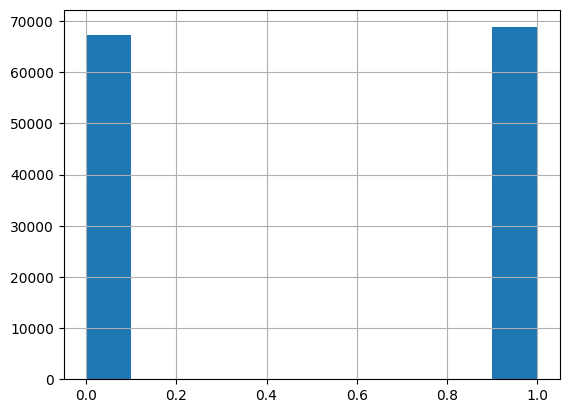

In [63]:
# Проверим сбалансированность выборки
df_train['label'].hist()

Выборка сбалансированна, следовательно нам не нужно будет прибегать к дополнительной обработке данных.

Перед построением моделей, нам необходимо очистить текстовые данные от лишних символов и слов, которые будут вносить "шум" и мешать модели обучаться.

Для начала с помощью облака слов визуально оценим какие слова встречаются чаще всего.

In [32]:
# функции для подготовки данных для построения облака слов
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                         ).generate(str_corpus(corpus))
    return wordCloud

<AxesSubplot: >

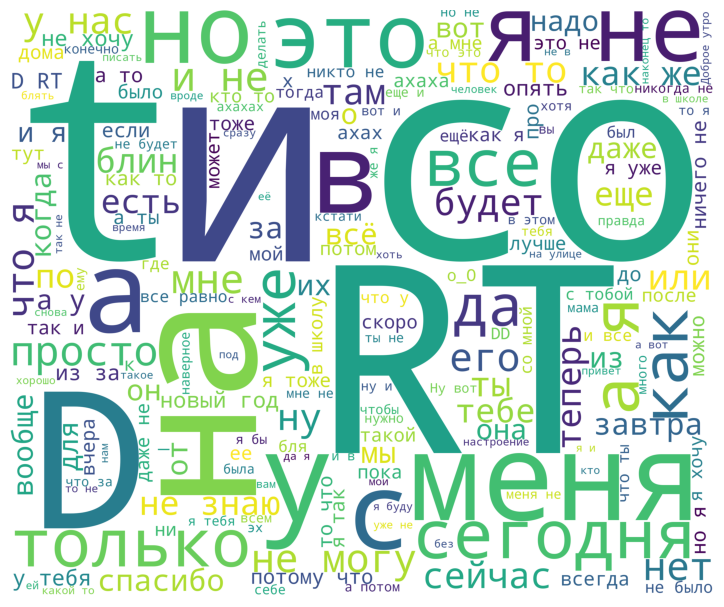

In [33]:
corpus = get_corpus(df_train['text'].values)
procWordCloud = get_wordCloud(corpus)
# отрисовка облака слов
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Как можно увидеть часто встречающиеся слова являются просто шумом, который будет мешать при обучении модели

In [34]:
# Удаление знаков пунктуации из текста
def remove_punct(text):
    # используем генераторы словарей для составления таблиц перевода
    # цифры соответствуют ASCII кодам знаков пунктуации (заменить знак на пробел)
    x1 = {x: ' ' for x in range(33, 48)}
    x2 = {x: ' ' for x in range(58, 65)}
    x3 = {x: ' ' for x in range(91, 97)}
    x4 = {x: ' ' for x in range(123, 127)}
    # объединяем все в один словарь
    table = x1 | x2 | x3 | x4
    # уберем скобки из таблицы, они могут служить хорошим индикатором тональности предложения
    table.pop(40)
    table.pop(41)
    return text.translate(table)

In [35]:
def remove_eng(text):
    # аналогично используем генераторы словарей
    # цифры соответствуют большим и маленьким латинским буквам
    t1 = {x: ' ' for x in range(65, 91)}
    t2 = {x: ' ' for x in range(97, 123)}
    table = t1 | t2
    # уберем "D" из таблицы этот символ часто встречается и может использоваться в качестве смайлика
    # и может стать хорошим индикатором тональности предложения
    table.pop(68)
    return text.translate(table)

In [36]:
# берем список русских слов, которые могут затруднить обучение модели
russian_stopwords = stopwords.words("russian")
# уберем из этого списка некоторые, которые на мой взгляд могут служить индикаторами тональности предложения
russian_stopwords.remove('совсем')
russian_stopwords.remove('никогда')
russian_stopwords.remove('больше')
russian_stopwords.remove('хорошо')
russian_stopwords.remove('лучше')
russian_stopwords.remove('нельзя')
russian_stopwords.remove('конечно')
# и добавим некоторые, которых в изначальном списке нет
russian_stopwords.append('сегодня')
russian_stopwords.append('завтра')
russian_stopwords.append('вчера')
russian_stopwords.append('тебе')
russian_stopwords.append('это')

In [37]:
# создадим отдельную колонку где будут храниться отчищинные текста
# приводим буквы к нижнему ригистру
df_train['clean_text'] = df_train['text'].map(lambda x: x.lower())
# удаляем знаки пунктуации
df_train['clean_text'] = df_train['clean_text'].map(lambda x: remove_punct(x))
# удаляем английские буквы
df_train['clean_text'] = df_train['clean_text'].map(lambda x: remove_eng(x))
# превращаем строки в списки слов
df_train['clean_text'] = df_train['clean_text'].map(lambda x: x.split(' '))
# проходим по спискам и удаляем стоп-слова и пробелы
df_train['clean_text'] = df_train['clean_text'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
# приводим списки обратно к строкам
df_train['clean_text'] = df_train['clean_text'].map(lambda x: ' '.join(x))

In [38]:
df_train

,text,label,clean_text
0,На нас обиделась Оля....Жизнь потеряла смысл. ...,0,обиделась оля жизнь потеряла смысл специально ...
1,RT @PolinaZuzy: http://t.co/ZYwbUowIti единств...,1,единственное порадовало сегодня)
2,"@AHamueva Машину назвать малышкой,мать ты ебу ...",1,машину назвать малышкой мать ебу дала
3,RT @malina23_: отличный день в школе!:*теперь ...,1,23 отличный день школе перемены вами викадашасаша
4,@Serebryakovaaa не то слово))) у него что ни м...,1,слово))) монолог точку
...,...,...,...
136095,А Зоя и Рита Шабановы все-таки сучки. Р.S. М...,1,зоя рита шабановы таки сучки р маринка точно п...
136096,@nvarlygina я все пропустила!:( ну хоть ты заг...,0,пропустила загадала надеюсь нормальное типо за...
136097,"RT @milkiwey_: выходные были хорошими, даже яр...",1,выходные хорошими яркими очень
136098,"@leshqa_meow ахахах, ну ты же стааарше меня, м...",1,ахахах стааарше нужна поддержка против кому


Посмотрим как теперь будет выглядеть облако слов

<AxesSubplot: >

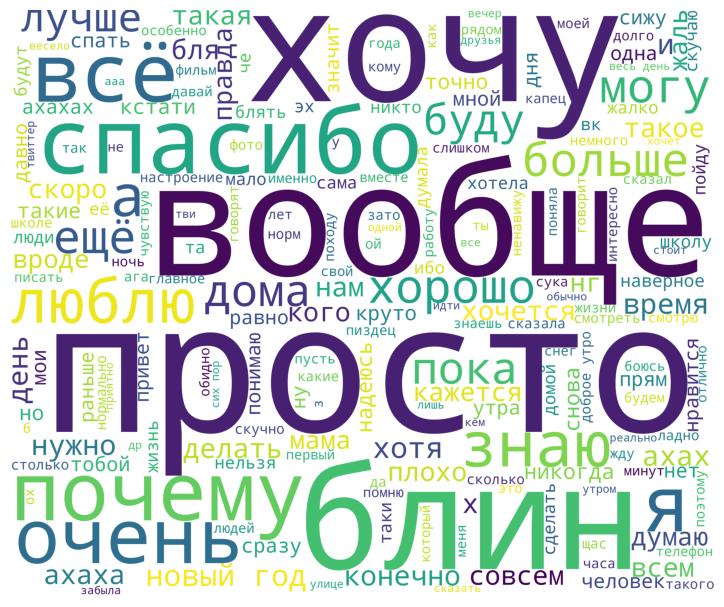

In [39]:
corpus = get_corpus(df_train['clean_text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

На мой взгляд смысла стало намного больше.

Теперь пора разрабатывать модель. Чтобы проверить работу модели разобьем тренировочный сет на тренировочную и тестовую выборки. (Я буду считать что в файле test.csv содержатся валидационные данные, которые в конечном итоге и оценят качество модели)

ПРИМЕЧАНИЕ: Я использую, SGDClassifier, т.к. для этого алгоритма мой рабочий ноутбук позволяет производить поиск оптимальных параметров за адекватное время. Более сложные алгоритмы обучаются слишком долго.

In [40]:
# создаем обучающую и тестовую выборки
train_features, test_features, train_target, test_target = train_test_split(df_train['clean_text'], 
                                                                            df_train['label'], 
                                                                            test_size=0.25, 
                                                                           )

# Поиск оптимальных параметров SGDClassifier

In [41]:
# TfidfVectorizer преобразует тексты в числовые вектора, 
# отражающие важность использования каждого слова из некоторого набора слов
# Создаем пайплайн из векторизатора и классификатора
steps = [('tfidf', TfidfVectorizer()), ('classifier', SGDClassifier())]

pipe = Pipeline(steps)
# определяем сетку параметров для GridSearch
# колличество параметров ограничено в целях оптимизации расчетов
params = {'classifier__loss':['hinge', 'modified_huber', 'perceptron'],
          'classifier__class_weight':['balanced'],
          'classifier__penalty':['l2', 'l1'],
          'classifier__n_jobs':[-1],
          'tfidf__ngram_range':[(1,2), (2,3)]
         }

sgd_classifier = GridSearchCV(pipe,
                              params,
                              scoring='f1', # ищем параметры где f-мера будет наибольшей
                              cv=3,         # используем 3-fold валидацию
                              n_jobs=-1     # задействовать все ядра процессора для расчетов
                             )

In [42]:
# обучение классификатора
sgd_classifier.fit(train_features, train_target)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced'],
                         'classifier__loss': ['hinge', 'modified_huber',
                                              'perceptron'],
                         'classifier__n_jobs': [-1],
                         'classifier__penalty': ['l2', 'l1'],
                         'tfidf__ngram_range': [(1, 2), (2, 3)]},
             scoring='f1')

In [43]:
# смотрим лучшие параметры
sgd_classifier.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__loss': 'modified_huber',
 'classifier__n_jobs': -1,
 'classifier__penalty': 'l2',
 'tfidf__ngram_range': (1, 2)}

In [44]:
# смотрим как хорошо классификатор справляется с обучающими данными
predicted = sgd_classifier.predict(train_features)
print(classification_report(predicted, train_target))
print(confusion_matrix(predicted, train_target))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     48701
           1       0.92      0.88      0.90     53374

    accuracy                           0.90    102075
   macro avg       0.90      0.90      0.90    102075
weighted avg       0.90      0.90      0.90    102075

[[44371  4330]
 [ 6230 47144]]


In [45]:
# смотрим как хорошо классификатор справляется с тестовыми данными
predicted = sgd_classifier.predict(test_features)
print(classification_report(predicted, test_target))
print(confusion_matrix(predicted, test_target))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72     16049
           1       0.75      0.72      0.74     17976

    accuracy                           0.73     34025
   macro avg       0.73      0.73      0.73     34025
weighted avg       0.73      0.73      0.73     34025

[[11754  4295]
 [ 4963 13013]]


# Итоговая модель

In [50]:
# на основе поиска по сетке создаем классификатор с определенными параметрами
steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
         ('classifier', SGDClassifier(loss='modified_huber', class_weight='balanced', penalty='l2', n_jobs=-1))
        ]
model = Pipeline(steps)
# и обучаем его на всем треннировочном датасете
model.fit(df_train['clean_text'], df_train['label'])

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               n_jobs=-1))])

In [51]:
# финальная проверка
predicted = model.predict(df_train['clean_text'])
print(classification_report(predicted, df_train['label']))
print(confusion_matrix(predicted, df_train['label']))
# f-мера равна 0.87, буду считать приемлимым результатом

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     64642
           1       0.89      0.86      0.87     71458

    accuracy                           0.87    136100
   macro avg       0.87      0.87      0.87    136100
weighted avg       0.87      0.87      0.87    136100

[[57166  7476]
 [10152 61306]]


In [55]:
# теперь делаем предсказания для test.csv на не очищенных данных
preds = model.predict(df_test['text'])
# формируем датафрейм
prediction = pd.DataFrame()
prediction['index'] = df_test['index']
prediction['label'] = preds
prediction

,index,label
0,61947,1
1,208586,0
2,187819,1
3,5277,0
4,149042,1
...,...,...
90729,172107,1
90730,172133,1
90731,172270,0
90732,104962,0


In [60]:
# сохраняем датафрейм в файл csv
prediction.to_csv('prediction.csv', sep=';', index=False)

# P.S.

У меня есть несколько мыслей по улучшению качества моделей:

1. Использовать лемматизацию, т.е. привести слова к нормальной форме, возможно это улучшит качество модели
2. Встроить очистку текста в пайплайн модели, чтобы она сама отчищала входные данные от лишних символов, в данном случае я намеренно передал не очищенные тестовые данные для формирования предсказаний
3. Использовать ансамблевые алгоритмы бустинга или бэггинга, или нейронные сети. В данной работе я этого не сделал в виду технических ограничений.